# Structure property relationship analysis

This notebook explore the different structure property relationship analysis within the dataset. 

In [272]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt

from func import calc_atomisation_energy

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from colors import cmap, heterocycles_colors, kde_kwargs

# Reload imported libraries automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the dataset

In [3]:
df = pd.read_csv(".temp/data/compas-2x.csv", index_col=0).query('charge == 0').copy()
lala = pd.read_csv(".temp/data/compas-2x-lala.csv", index_col=0)
df = df.merge(lala[['name','lala', 'stereo', 'types']])

In [4]:
# electronic properties
props = ['homo_corr','lumo_corr','gap_corr','aip_corr','aea_corr','aepe_corr']

# group by
hue_by = ['rings', 'aromatic_rings', 'atoms', 'heteroatoms', 'heterocycles',
       'branch', 'cyclobutadiene', 'pyrrole', 'borole', 'furan', 'thiophene',
       'dhdiborinine', '14diborinine', 'pyrazine', 'pyridine', 'borinine',
       'benzene', 'h', 'c', 'b', 's', 'o', 'n']

In [6]:
def get_query(bblock):
    query = "benzene != 0 "
    for ring in heterocycles_colors.keys():
        if ring == "benzene": continue
        if ring == bblock: 
            query += f"& `{ring}` != 0 "
            continue
        query += f"& `{ring}` == 0 "
    return query

In [8]:
import re

def get_longest_anti(s):
    adjacent_anti = re.compile('[AF]+')
    matches = adjacent_anti.findall(s)
    longest = 0
    results = ''
    for m in matches:
        if len(m) > longest:
            longest = len(m)
            results = m
    return longest

def get_longest_helix(s,):
    global direction
    clockwise = re.compile(f'\{direction}+')
    branches = re.compile('\(.+?\)')
    matches = clockwise.findall(s)

    longest = 0
    results = ''
    for m in matches:
        m = branches.sub('', m)
        if len(m) > longest:
            longest = len(m)
            results = m
    return longest


def get_longest_L(s):
    adjacent_ls = re.compile('L+')
    matches = adjacent_ls.findall(s)
    
    longest = 0
    results = ''
    for m in matches:
        if len(m) > longest:
            longest = len(m)
            results = m
    return longest

def get_longest_A(s):
    adjacent_as = re.compile('[TA]+\(.+?\)[TA]+')
    branches = re.compile('\(.+?\)')
    matches = adjacent_as.findall(s)

    longest = 0
    results = ''
    for m in matches:
        m = branches.sub('', m)
        if len(m) > longest:
            longest = len(m)
            results = m
    return longest

df['longest_l'] = df['lala'].apply(get_longest_L)
df['longest_a'] = df['lala'].apply(get_longest_A)

df['longest_anti'] = df['types'].apply(get_longest_anti)

direction = '+'
df['longest_right'] = df['stereo'].apply(get_longest_helix)
direction = '-'
df['longest_left'] = df['stereo'].apply(get_longest_helix)

In [9]:
def plotkde_properties_hued_by(dataset, hue, remove_legend=False, **kwargs):
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    axs = axs.flatten()
    for i, prop in enumerate(props):
        sns.kdeplot(data=dataset, x=prop, 
                    fill=True,
                    hue=hue,
                    warn_singular=False,
                    ax=axs[i],
                    **kwargs
                    )
        if remove_legend: axs[i].legend_.remove()
        remove_legend = True
    fig.suptitle(f"Color by {hue}")
    plt.tight_layout()
    return fig, axs

def plothist_properties_hued_by(dataset, hue, remove_legend=False, **kwargs):
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    axs = axs.flatten()
    for i, prop in enumerate(props):
        sns.histplot(data=dataset, x=prop, 
                    fill=True,
                    hue=hue,
                    ax=axs[i],
                    **kwargs
                    )
        if remove_legend: axs[i].legend_.remove()
        remove_legend = True
    fig.suptitle(f"Color by {hue}")
    plt.tight_layout()
    return fig, axs

# Kernel Density Estimation of Molecular Properties, Colored by Atom Rings

The figure displays Kernel Density Estimation (KDE) plots for various molecular properties (homo, lumo, gap, aea, aip, and aepe), each colored by the number of atom rings (rings). The six subplots correspond to different properties, providing a comparative view of their distributions based on the molecule's ring count. For each subplot, the KDE curves showcase the probability density functions of the respective molecular property, with distinctive colors representing different atom ring categories.

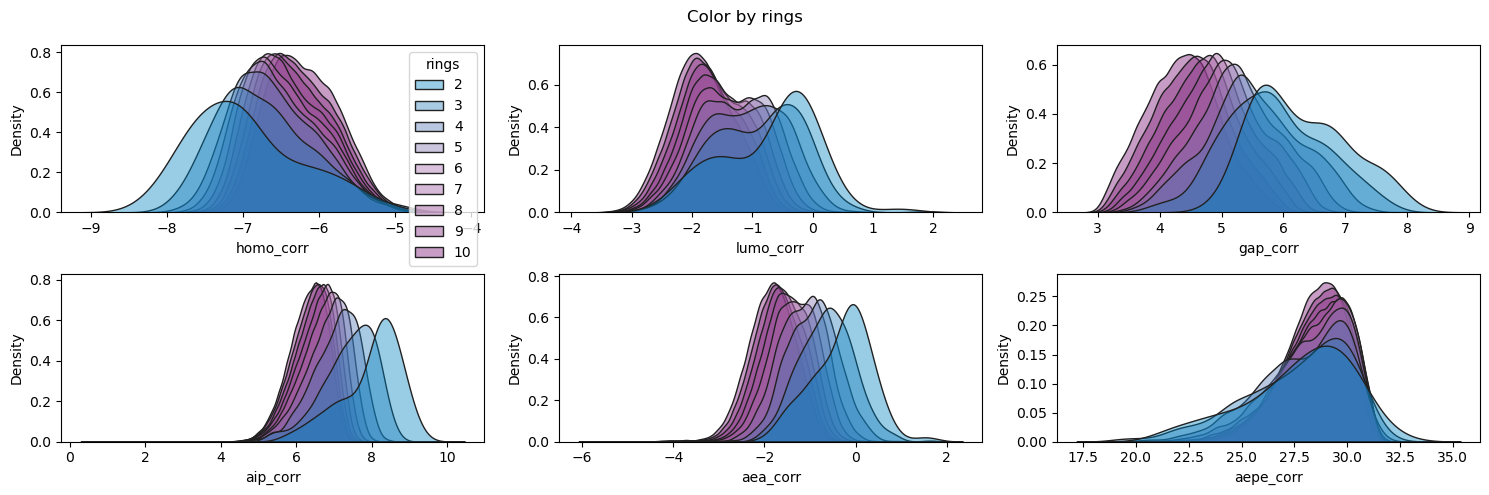

In [9]:
for hue in ['rings']:
    # hue_order == hue_order[::-1]
    fig = plotkde_properties_hued_by(df, hue,
                    **kde_kwargs
                    )
    plt.savefig(f'.temp/figures/properties_hued_by_{hue}.png', dpi=300)
    plt.savefig(f'.temp/figures/properties_hued_by_{hue}.svg', dpi=300)